<a href="https://colab.research.google.com/github/SorenKyhl/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [231]:
# Import torch
import torch
%config InlineBackend.figure_format='retina'

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [232]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(1000, noise=0.2)

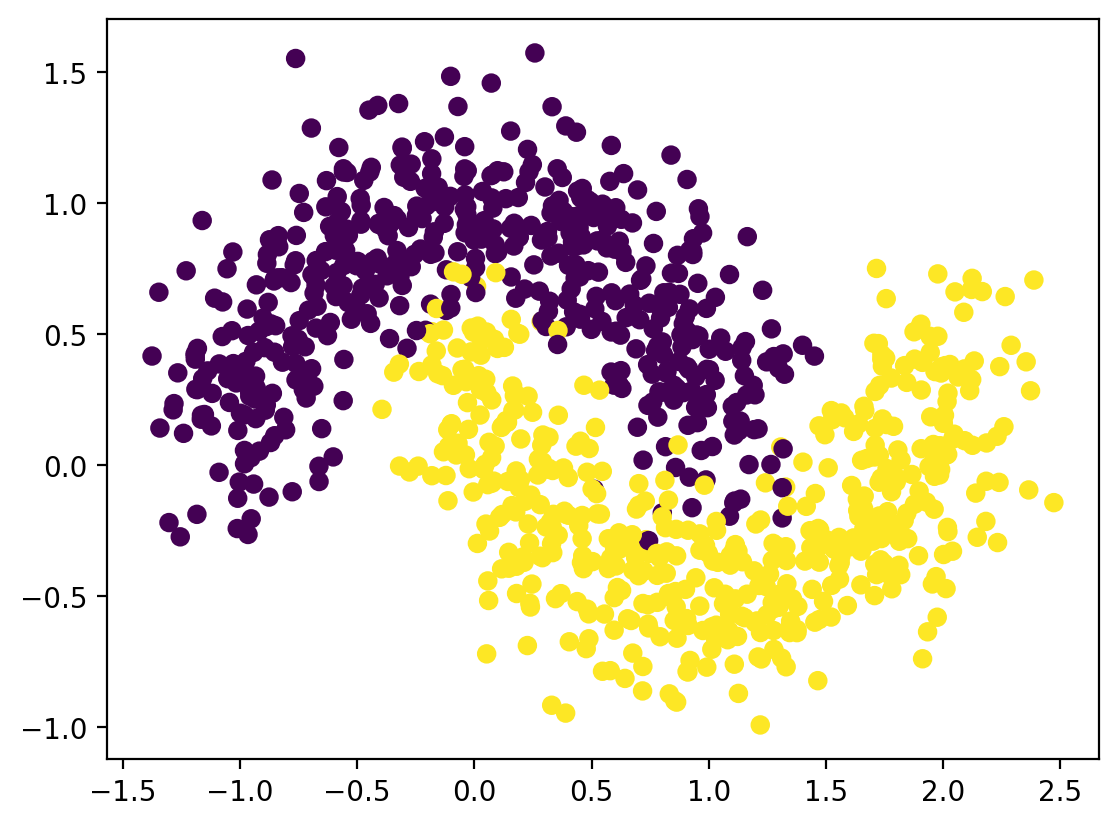

In [233]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y)

In [234]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)


X, y = X.to(device), y.to(device)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
print(xtrain.shape, xtest.shape)

torch.Size([800, 2]) torch.Size([200, 2])


In [235]:
print(xtrain.shape, xtest.shape)
print(xtrain.device)

torch.Size([800, 2]) torch.Size([200, 2])
cpu


## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [236]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 5)
    self.layer2 = nn.Linear(5, 5)
    self.layer3 = nn.Linear(5, 1)
    self.activ = nn.Sigmoid()

  def forward(self, x):
      return self.layer3(self.activ(self.layer2(self.activ(self.layer1(x)))))

# Instantiate the model
model0 = MoonModelV0()
model0.to(device)
print(model0)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=1)

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=1, bias=True)
  (activ): Sigmoid()
)


## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [237]:
def inference(x, model):
  return preds_from_logits(model(x).squeeze())

def preds_from_logits(x, multiclass=False):
  if multiclass:
    return torch.argmax(torch.softmax(x, dim=1), dim=1).int()
  else:
    return torch.round(torch.sigmoid(x)).int()

In [238]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
logits = model0(xtrain).squeeze()
print(logits[0])

# Prediction probabilities
print("Pred probs:")
probs = torch.sigmoid(logits)
print(probs[0])

# Prediction labels
print("Pred labels:")
preds = torch.round(probs)
print(preds[0].int())

Logits:
tensor(-0.4595, grad_fn=<SelectBackward0>)
Pred probs:
tensor(0.3871, grad_fn=<SelectBackward0>)
Pred labels:
tensor(0, dtype=torch.int32)


In [239]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
#!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device

In [240]:
epochs = []
losses = []
accs = []
testlosses = []
testaccs = []

In [241]:
def fulltrain(model0, n_epochs, multiclass=False):
  torch.manual_seed(RANDOM_SEED)

  model0.to(device)

  if len(epochs) == 0:
    start = 0
  else:
    start = epochs[-1]

  for epoch in range(start, start+n_epochs):
    model0.train()

    ylogits = model0(xtrain).squeeze()
    ypred = preds_from_logits(ylogits, multiclass)

    loss = loss_fn(ylogits, ytrain)
    acc = acc_fn(ypred, ytrain.int())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epochs.append(epoch)
    losses.append(loss.item())
    accs.append(acc.item())

    # Testing
    model0.eval()
    with torch.inference_mode():
      ylogits = model0(xtest).squeeze()
      ypred = preds_from_logits(ylogits, multiclass)

      loss = loss_fn(ylogits, ytest)
      acc = acc_fn(ypred, ytest.int())

      testlosses.append(loss.item())
      testaccs.append(acc.item())

    if epoch % 200 == 0:
      print(f"--------- Epoch{epoch} ---------")
      print(f"loss: {loss} \t acc:{acc}")

In [246]:
fulltrain(model0, 2000)

--------- Epoch2000 ---------
loss: 0.14875510334968567 	 acc:0.9599999785423279
--------- Epoch2200 ---------
loss: 0.09296765923500061 	 acc:0.9700000286102295
--------- Epoch2400 ---------
loss: 0.07827034592628479 	 acc:0.9800000190734863
--------- Epoch2600 ---------
loss: 0.0730542540550232 	 acc:0.9800000190734863
--------- Epoch2800 ---------
loss: 0.07084697484970093 	 acc:0.9800000190734863
--------- Epoch3000 ---------
loss: 0.06979293376207352 	 acc:0.9750000238418579
--------- Epoch3200 ---------
loss: 0.06920957565307617 	 acc:0.9750000238418579
--------- Epoch3400 ---------
loss: 0.06880635023117065 	 acc:0.9700000286102295
--------- Epoch3600 ---------
loss: 0.06846001744270325 	 acc:0.9700000286102295
--------- Epoch3800 ---------
loss: 0.06812611222267151 	 acc:0.9700000286102295


In [247]:
def plot_loss():
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.plot(epochs, losses, label="train loss")
  plt.plot(epochs, testlosses, label="test loss")
  plt.subplot(1,2,2)
  plt.plot(epochs, accs, label="train acc")
  plt.plot(epochs, testaccs, label="test acc")
  plt.legend()

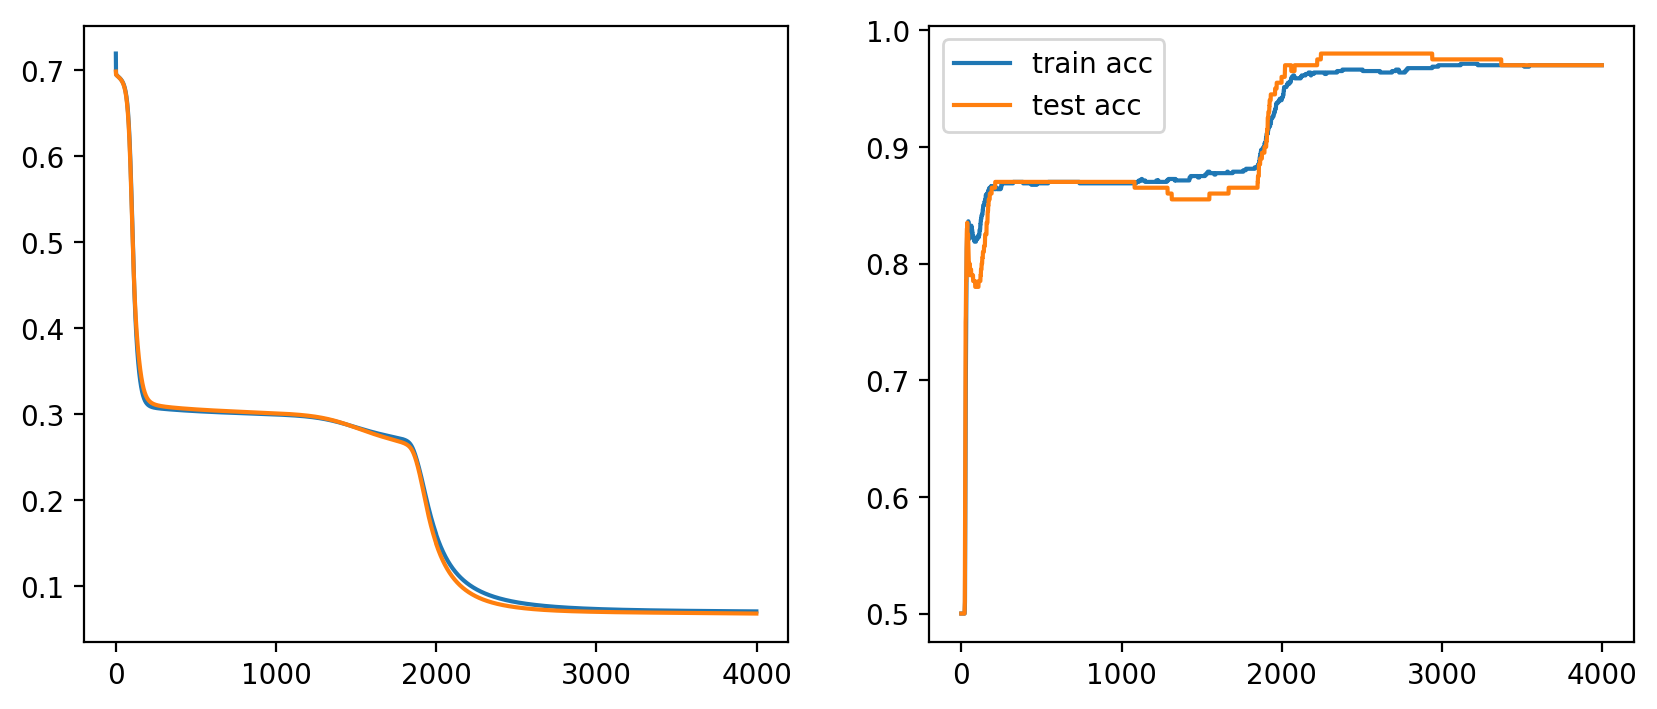

In [248]:
plot_loss()

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [36]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

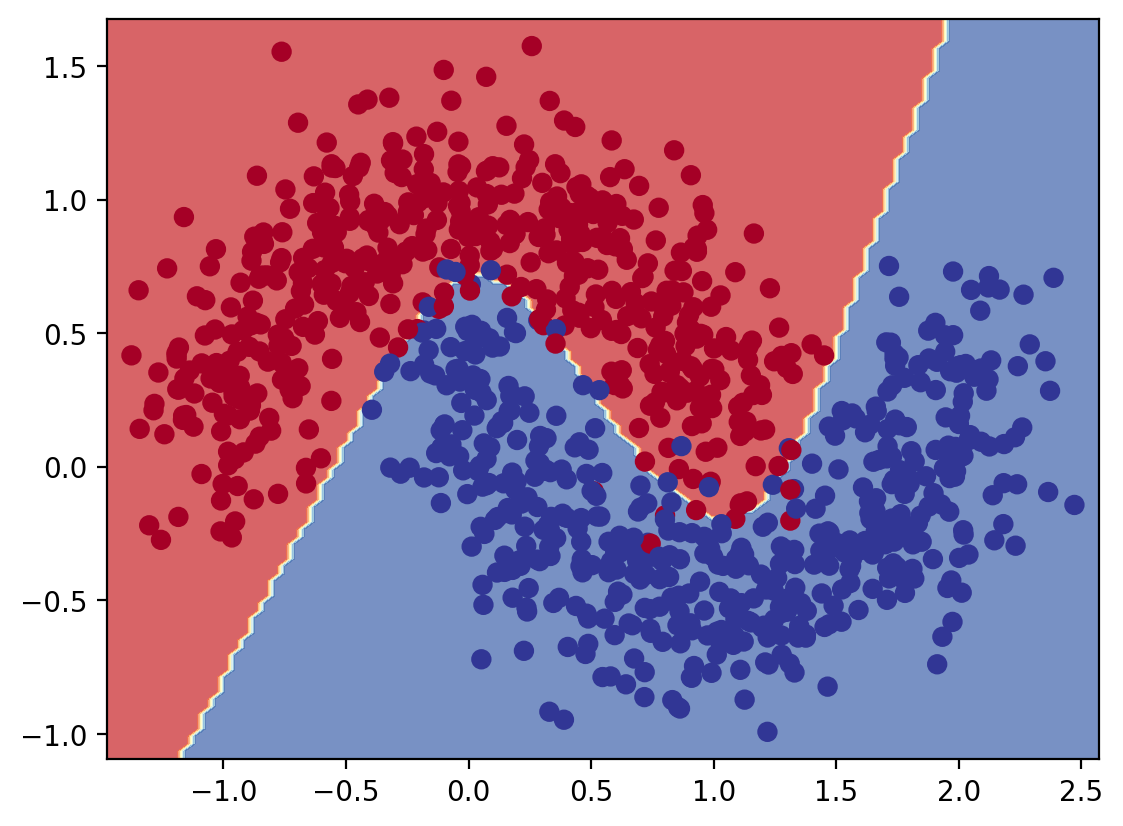

In [249]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model0, X, y)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [ ]:
# Create a straight line tensor


In [ ]:
# Test torch.tanh() on the tensor and plot it


In [ ]:
# Replicate torch.tanh() and plot it


## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

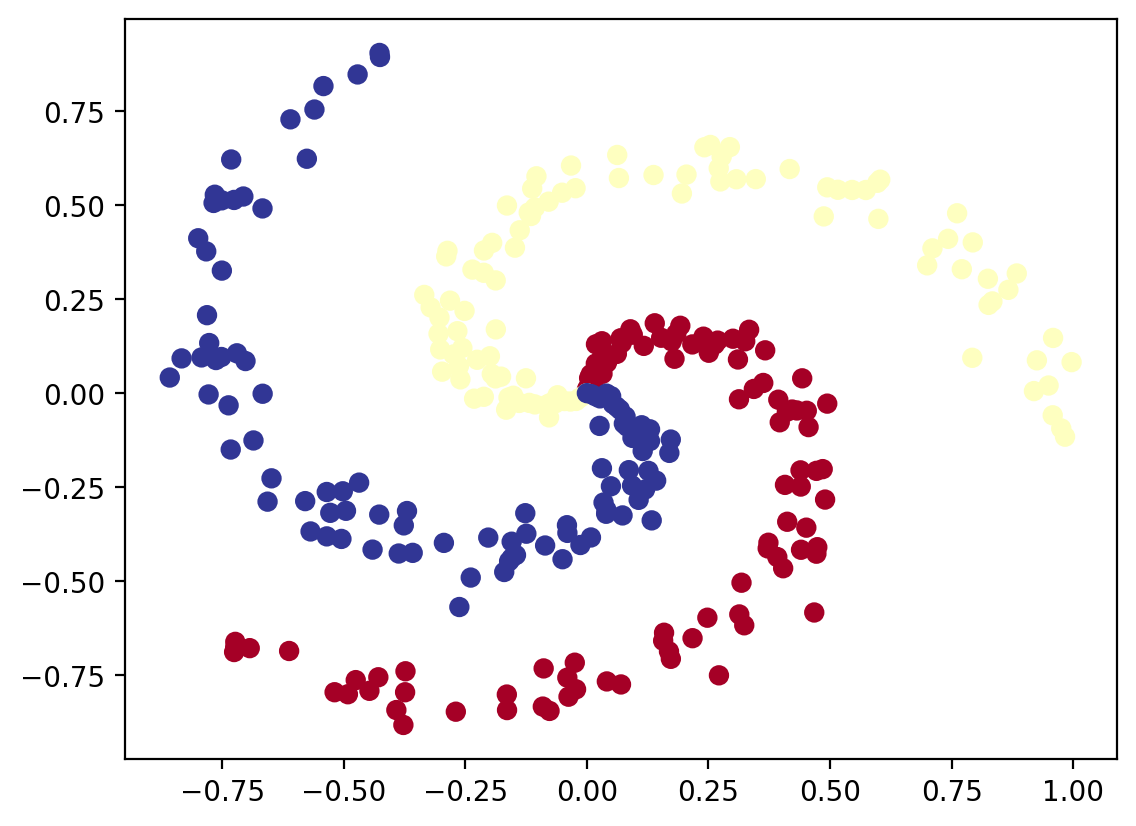

In [55]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [56]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

X.to(device)
y.to(device)

# Create train and test splits
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [148]:
# Let's calculuate the accuracy for when we fit our model
#!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)


In [208]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2,5)
    self.layer2 = nn.Linear(5,5)
    self.layer3 = nn.Linear(5,3)
    self.activ = nn.Sigmoid()

  def forward(self, x):
    return self.layer3(self.activ(self.layer2(self.activ(self.layer1(x)))))


multimodel = SpiralModelV0()
multimodel.to(device)
print(multimodel)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=multimodel.parameters(), lr=0.5)

SpiralModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=3, bias=True)
  (activ): Sigmoid()
)


In [209]:
# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
logits = multimodel(xtrain)
print(logits[:10])

print("Pred probs:")
probs = torch.softmax(logits, 1)
print(probs[:10])

print("Pred labels:")
preds = torch.argmax(probs, dim=1)
print(preds[:10])

Logits:
tensor([[ 0.0214, -0.4372,  0.3159],
        [ 0.0174, -0.4316,  0.3143],
        [ 0.0176, -0.4317,  0.3146],
        [ 0.0207, -0.4375,  0.3144],
        [ 0.0241, -0.4438,  0.3143],
        [ 0.0194, -0.4349,  0.3145],
        [ 0.0211, -0.4388,  0.3133],
        [ 0.0208, -0.4382,  0.3132],
        [ 0.0175, -0.4307,  0.3150],
        [ 0.0198, -0.4356,  0.3146]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3362, 0.2125, 0.4513],
        [0.3351, 0.2139, 0.4510],
        [0.3351, 0.2138, 0.4510],
        [0.3363, 0.2127, 0.4511],
        [0.3375, 0.2114, 0.4511],
        [0.3358, 0.2132, 0.4510],
        [0.3366, 0.2125, 0.4509],
        [0.3365, 0.2127, 0.4508],
        [0.3350, 0.2140, 0.4511],
        [0.3359, 0.2130, 0.4511]], grad_fn=<SliceBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [210]:
epochs = []
losses = []
accs = []
testlosses = []
testaccs = []

In [224]:
# Plot decision boundaries for training and test sets
fulltrain(multimodel, 2000, multiclass=True)

--------- Epoch8000 ---------
loss: 0.051309455186128616 	 acc:0.9866666793823242
--------- Epoch8200 ---------
loss: 0.050405099987983704 	 acc:0.9866666793823242
--------- Epoch8400 ---------
loss: 0.04956160485744476 	 acc:0.9866666793823242
--------- Epoch8600 ---------
loss: 0.04877282306551933 	 acc:0.9866666793823242
--------- Epoch8800 ---------
loss: 0.04803329333662987 	 acc:0.9866666793823242
--------- Epoch9000 ---------
loss: 0.0473383367061615 	 acc:0.9866666793823242
--------- Epoch9200 ---------
loss: 0.04668412730097771 	 acc:0.9866666793823242
--------- Epoch9400 ---------
loss: 0.04606703668832779 	 acc:0.9866666793823242
--------- Epoch9600 ---------
loss: 0.04548417031764984 	 acc:0.9866666793823242
--------- Epoch9800 ---------
loss: 0.044932473450899124 	 acc:0.9866666793823242


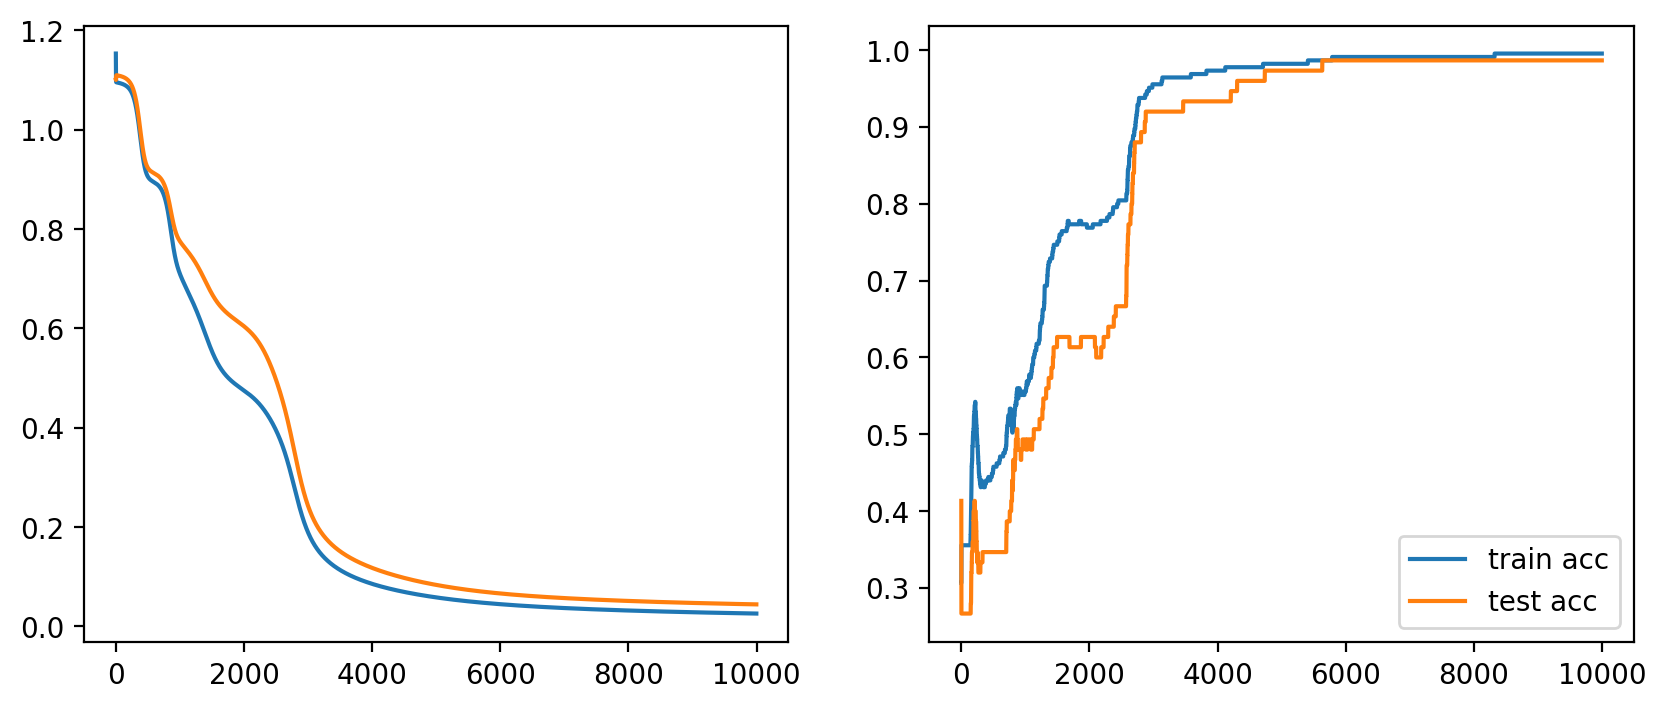

In [225]:
plot_loss()

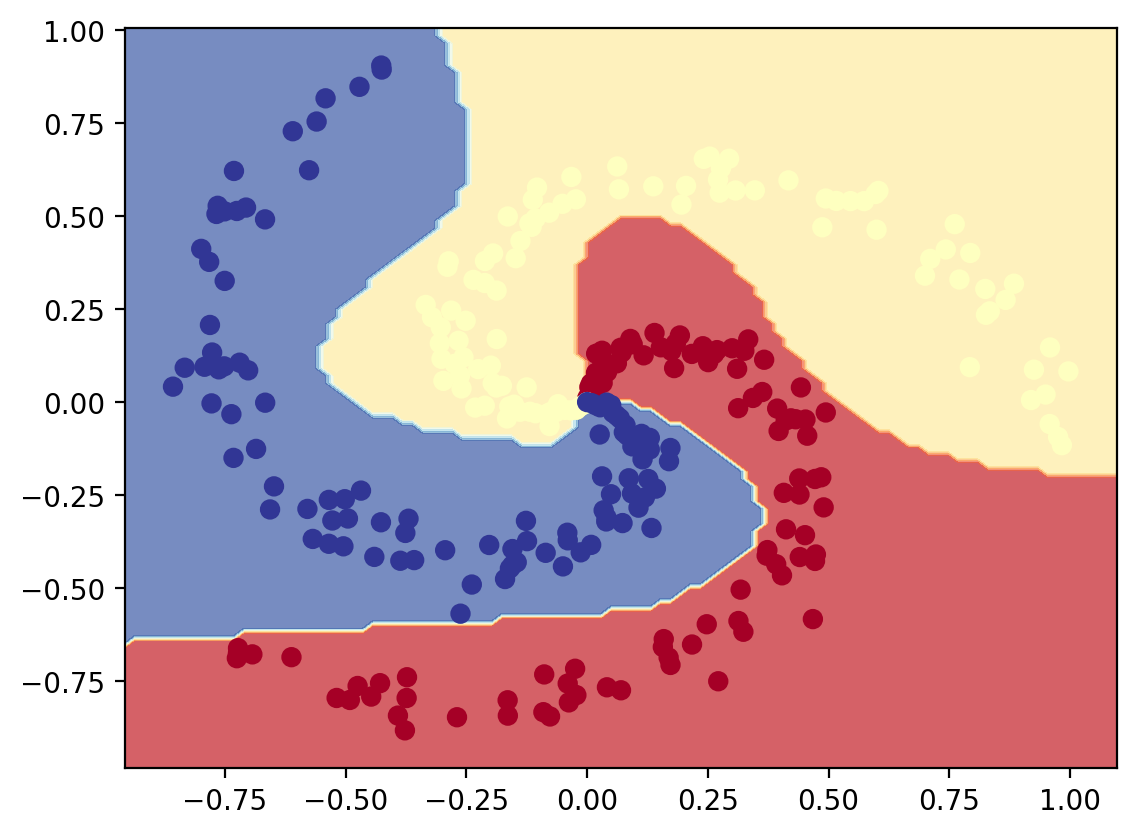

In [227]:
plot_decision_boundary(multimodel, X, y)